# Training the Model for Spotify Similar Song Finder

This notebook contains code for the Exploratory Data Analysis and Model Training sections of the project.

Due to not being able to get past Spotify's API rate limits, I will be using an already processed CSV file created by Cameron Watts.

### Imports

In [1]:
from __future__ import print_function

import os
import json
import time
import sys
from dotenv import load_dotenv

import pandas as pd
import numpy as np  
import seaborn as sn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors



import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

load_dotenv()
client_id = os.getenv("SPOTIPY_CLIENT_ID")
client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

### Load data

In [15]:
df=pd.read_csv('../data/spotify_data.csv')

In [12]:
df

,Unnamed: 0.1,Unnamed: 0,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_x,album_name,...,type,id,uri,track_href,analysis_url,duration_ms_y,time_signature,artist_pop,genres,track_pop
0,0,0,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
1,1,7734,73,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
2,2,14037,14,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
3,3,21536,42,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
4,4,24404,1,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67494,67494,67496,37,Jon D,3uCHI1gfOUL5j5swEh0TcH,spotify:artist:5HCypjplgh5uQezvBpOfXN,I Don't Know,spotify:album:2KEQtuVl1cYsTYtVRUrNVi,189183,Roots,...,audio_features,3uCHI1gfOUL5j5swEh0TcH,spotify:track:3uCHI1gfOUL5j5swEh0TcH,https://api.spotify.com/v1/tracks/3uCHI1gfOUL5...,https://api.spotify.com/v1/audio-analysis/3uCH...,189184,4,47,unknown,27
67495,67495,67499,40,Big Words,0P1oO2gREMYUCoOkzYAyFu,spotify:artist:0sHN89qak07mnug3LVVjzP,The Answer,spotify:album:5jrsRHRAmetu5e7RRBoxj7,263679,"Hollywood, a Beautiful Coincidence",...,audio_features,0P1oO2gREMYUCoOkzYAyFu,spotify:track:0P1oO2gREMYUCoOkzYAyFu,https://api.spotify.com/v1/tracks/0P1oO2gREMYU...,https://api.spotify.com/v1/audio-analysis/0P1o...,263680,4,39,australian_r&b,37
67496,67496,67500,41,Allan Rayman,2oM4BuruDnEvk59IvIXCwn,spotify:artist:6Yv6OBXD6ZQakEljaGaDAk,25.22,spotify:album:3CbNgBzI7r9o0F6VjH9sTY,189213,Roadhouse 01,...,audio_features,2oM4BuruDnEvk59IvIXCwn,spotify:track:2oM4BuruDnEvk59IvIXCwn,https://api.spotify.com/v1/tracks/2oM4BuruDnEv...,https://api.spotify.com/v1/audio-analysis/2oM4...,189213,4,55,canadian_contemporary_r&b modern_alternative_rock,49
67497,67497,67501,42,Jon Jason,4Ri5TTUgjM96tbQZd5Ua7V,spotify:artist:77bNdkKYBBmc30CisCA6tE,Good Feeling,spotify:album:2dZ7oVNQBeLlpoUYfbEsJP,194720,Good Feeling,...,audio_features,4Ri5TTUgjM96tbQZd5Ua7V,spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,https://api.spotify.com/v1/tracks/4Ri5TTUgjM96...,https://api.spotify.com/v1/audio-analysis/4Ri5...,194720,4,4,unknown,16


In [16]:
df = df.drop(columns=['Unnamed: 0', "Unnamed: 0.1", "pos", "artist_uri", "album_uri", "duration_ms_x", "album_name", "name", "type", "id", "track_href", "analysis_url", "duration_ms_y", "time_signature", "artist_pop", "track_pop"])

In [17]:
df

,artist_name,track_uri,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,genres
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.0311,0.006970,0.0471,0.810,125.461,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...
1,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.0311,0.006970,0.0471,0.810,125.461,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...
2,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.0311,0.006970,0.0471,0.810,125.461,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...
3,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.0311,0.006970,0.0471,0.810,125.461,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...
4,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.0311,0.006970,0.0471,0.810,125.461,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67494,Jon D,3uCHI1gfOUL5j5swEh0TcH,I Don't Know,0.669,0.228,2,-12.119,1,0.0690,0.7920,0.065000,0.0944,0.402,83.024,spotify:track:3uCHI1gfOUL5j5swEh0TcH,unknown
67495,Big Words,0P1oO2gREMYUCoOkzYAyFu,The Answer,0.493,0.727,1,-5.031,1,0.2170,0.0873,0.000000,0.1290,0.289,73.259,spotify:track:0P1oO2gREMYUCoOkzYAyFu,australian_r&b
67496,Allan Rayman,2oM4BuruDnEvk59IvIXCwn,25.22,0.702,0.524,7,-10.710,1,0.0793,0.3320,0.055300,0.2980,0.265,140.089,spotify:track:2oM4BuruDnEvk59IvIXCwn,canadian_contemporary_r&b modern_alternative_rock
67497,Jon Jason,4Ri5TTUgjM96tbQZd5Ua7V,Good Feeling,0.509,0.286,8,-14.722,1,0.1230,0.4020,0.000012,0.1310,0.259,121.633,spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,unknown


## EDA

In [18]:
df.isna().sum()

artist_name         0
track_uri           0
track_name          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
uri                 0
genres              0
dtype: int64

In [19]:
df.isnull().sum()   

artist_name         0
track_uri           0
track_name          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
uri                 0
genres              0
dtype: int64

In [20]:
df.dropna(inplace=True)
df.shape

(67499, 16)

In [21]:
df.dtypes

artist_name          object
track_uri            object
track_name           object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
uri                  object
genres               object
dtype: object

In [22]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,67499.000000,67499.000000,67499.00000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000
mean,0.608796,0.644026,5.16818,-7.213128,0.661951,0.096103,0.234351,0.049393,0.189541,0.496307,121.647678
std,0.160276,0.208183,3.61477,3.521258,0.473049,0.102514,0.276503,0.175005,0.155041,0.237812,28.863226
min,0.000000,0.000000,0.00000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.503000,0.510000,2.00000,-8.636000,0.000000,0.035800,0.021800,0.000000,0.094400,0.309000,99.051000
50%,0.617000,0.672000,5.00000,-6.474000,1.000000,0.051000,0.107000,0.000003,0.126000,0.489000,120.287000
75%,0.725000,0.807000,8.00000,-4.910000,1.000000,0.106000,0.365000,0.000579,0.242000,0.682000,140.021000
max,0.988000,1.000000,11.00000,2.766000,1.000000,0.962000,0.996000,0.995000,1.000000,0.998000,219.297000


array([[<Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'key'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>, <Axes: >]], dtype=object)

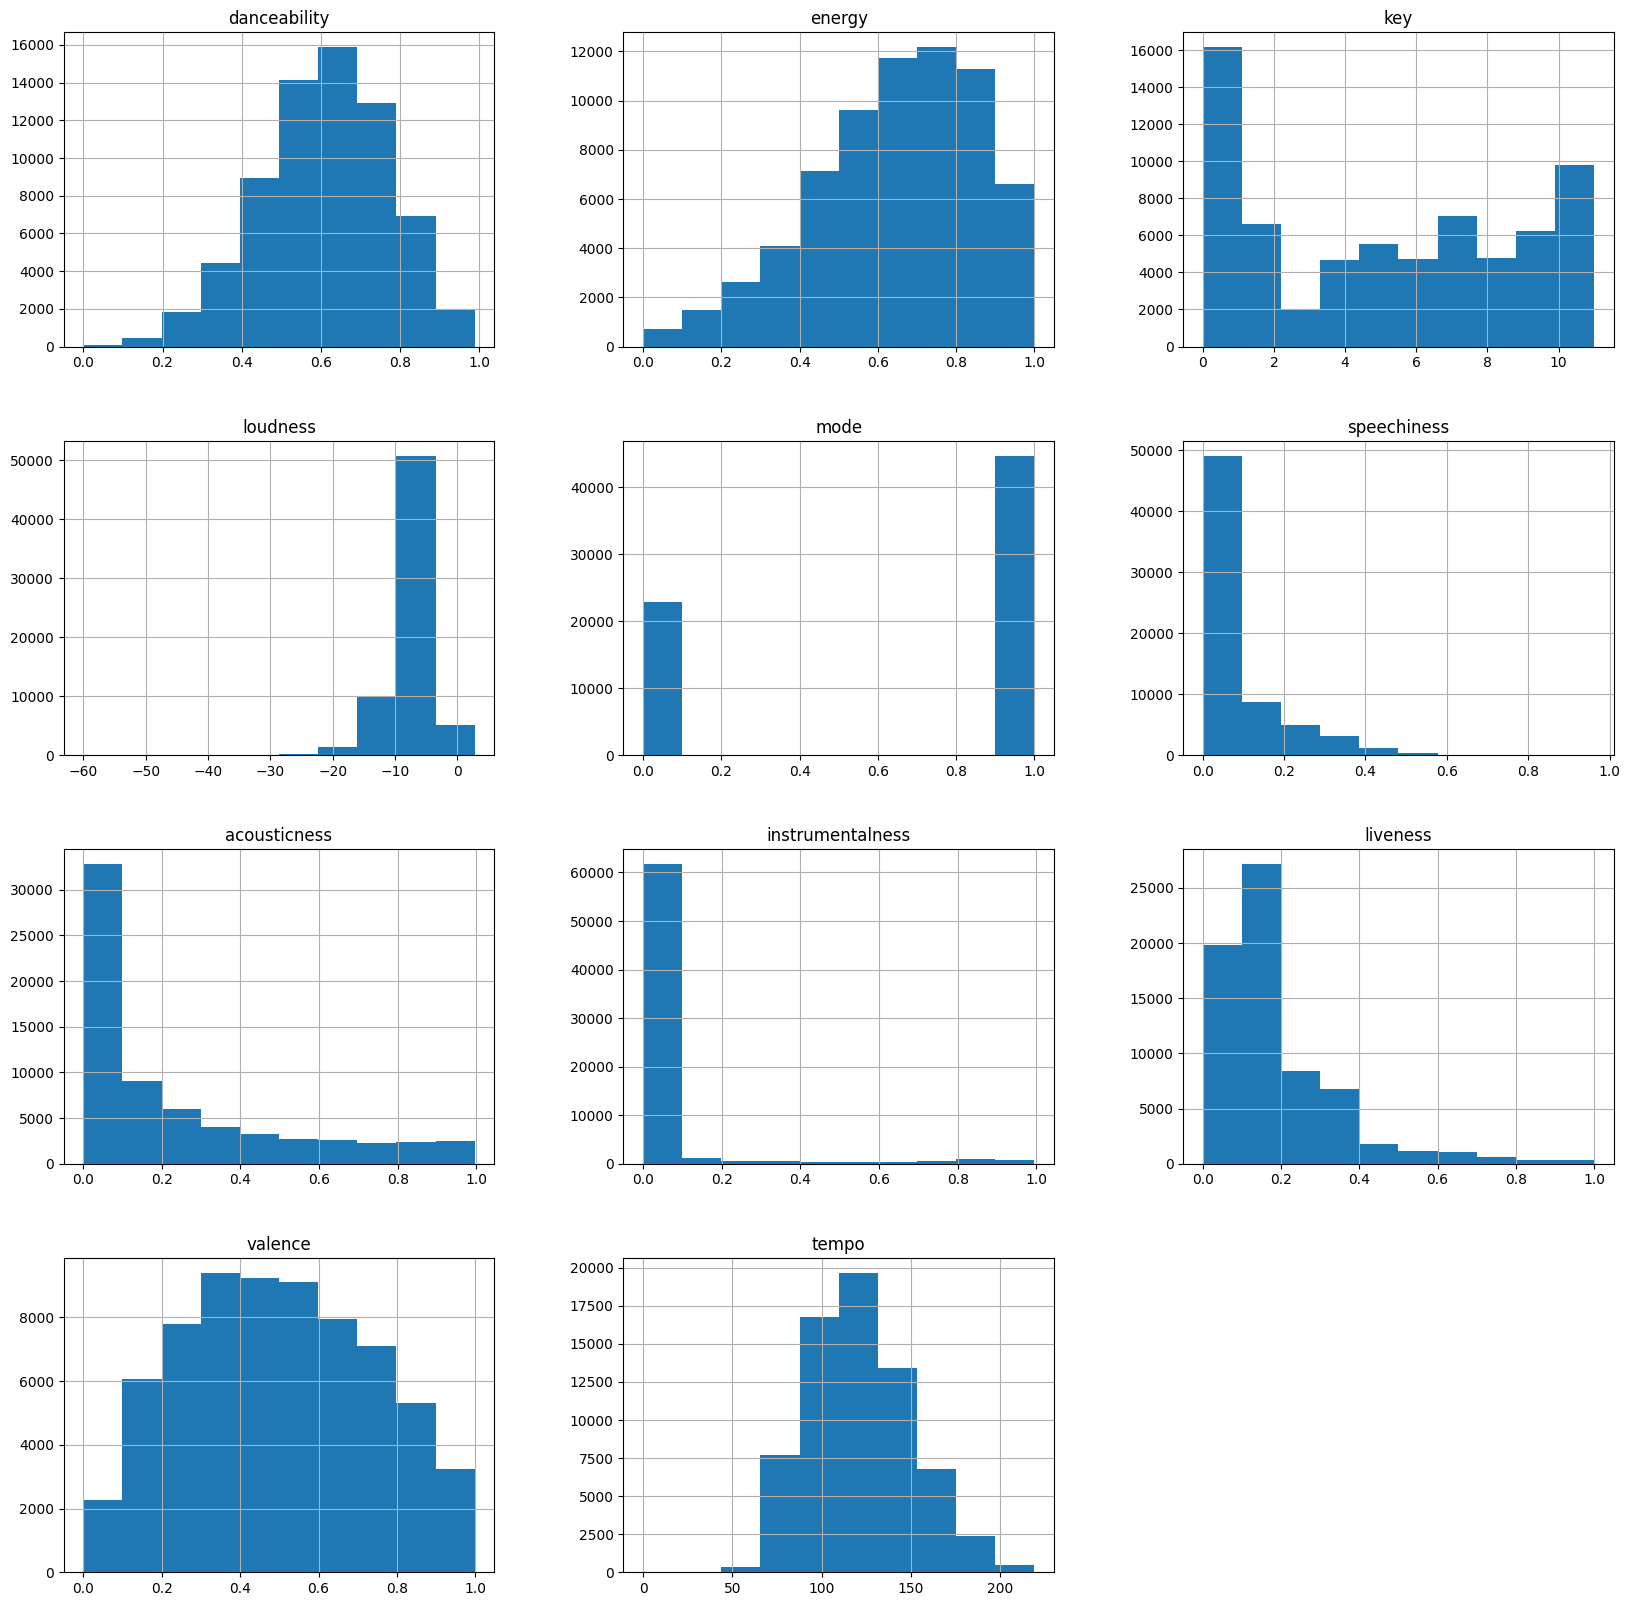

In [23]:
df.hist(figsize=(20,20))

For starters, I want to use all columns. Maybe later on PCA will be a good thing to do.

In [25]:
df_num = df.select_dtypes(include = ['float64', 'int64'])

<Axes: >

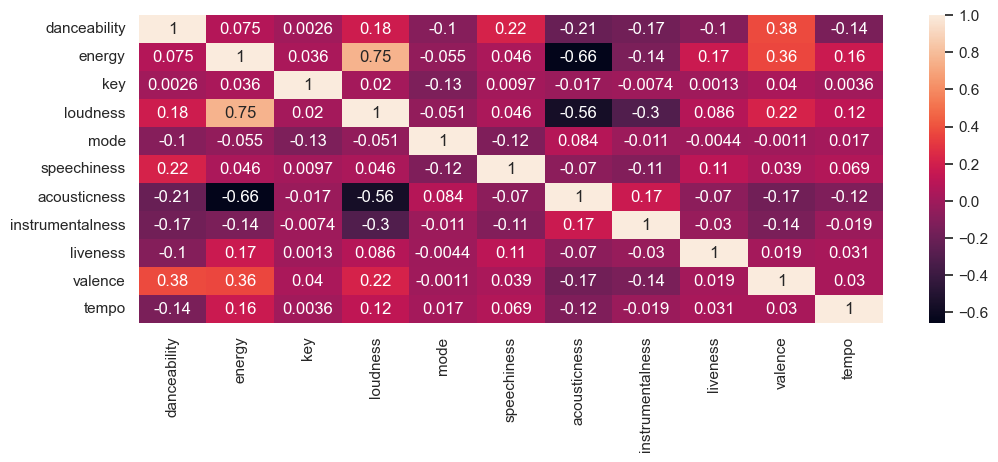

In [26]:
corr_matrix = df_num.corr()
sn.set (rc = {'figure.figsize':(12, 4)})
sn.heatmap(corr_matrix, annot=True)

### Encoding & Scaling

In [27]:
numeric_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
categorical_cols = ['key', 'mode']

# Create the preprocessing pipeline
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply the preprocessing pipeline to your DataFrame
df_processed = preprocessing_pipeline.fit_transform(df_num)

num_cols_transformed = numeric_cols
cat_cols_transformed = preprocessing_pipeline.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine the transformed column names
all_cols_transformed = num_cols_transformed + cat_cols_transformed.tolist()

# Convert the processed NumPy array back to a DataFrame
df_processed = pd.DataFrame(df_processed, columns=all_cols_transformed)


In [28]:
df_processed

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_0,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
0,-0.735083,1.841863,0.811665,-0.242410,-0.918738,0.030707,0.242866,0.132118,1.319089,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.735083,1.841863,0.811665,-0.242410,-0.918738,0.030707,0.242866,0.132118,1.319089,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.735083,1.841863,0.811665,-0.242410,-0.918738,0.030707,0.242866,0.132118,1.319089,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.735083,1.841863,0.811665,-0.242410,-0.918738,0.030707,0.242866,0.132118,1.319089,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.735083,1.841863,0.811665,-0.242410,-0.918738,0.030707,0.242866,0.132118,1.319089,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67494,2.016809,0.375628,-1.998383,0.089183,-0.613656,-1.393226,-0.264385,-1.338172,-0.396565,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
67495,-0.531829,-0.722488,0.398564,-0.282238,-0.390488,0.619706,1.179328,-1.676494,-0.871734,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
67496,0.353160,0.581525,-0.576547,0.033755,0.699552,-0.993082,-0.163910,0.638926,-0.972655,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
67497,0.606324,-0.622660,-1.719780,-0.282172,-0.377588,-2.132456,0.262375,-0.000509,-0.997886,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [15]:
# df_processed.hist(figsize=(20,20))

In [29]:

def transform_query(track_uri):
    audio_features = sp.audio_features(track_uri)[0]
    track_data = []
    track_dict = {
        'acousticness': audio_features['acousticness'],
        'danceability': audio_features['danceability'],
        'energy': audio_features['energy'],
        'instrumentalness': audio_features['instrumentalness'],
        'liveness': audio_features['liveness'],
        'loudness': audio_features['loudness'],
        'speechiness': audio_features['speechiness'],
        'tempo': audio_features['tempo'],
        'valence': audio_features['valence'],
        'key': audio_features['key'],
        'mode': audio_features['mode']
    }
    
    track_data.append(track_dict)
    query_data = pd.DataFrame(track_data)
    return query_data

In [30]:
knn_model = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean')
knn_model.fit(df_processed) # I'm using all the data for KNN

# Function to find similar songs to the input URI
def find_similar_songs(track_uri):

    query_data = transform_query(track_uri)
    
    # Scale the query data using the same scaler
    query_data_scaled = preprocessing_pipeline.transform(query_data)
    query_data_scaled_df = pd.DataFrame(query_data_scaled, columns=all_cols_transformed)

    # Find the most similar songs using the KNN model
    distances, indices = knn_model.kneighbors(query_data_scaled_df, n_neighbors=10)

    # Retrieve the Artist Name, Song Name, and Track URI of the most similar songs
    similar_songs = []
    for index in indices[0]:
        artist_name = df.iloc[index]['artist_name']
        song_name = df.iloc[index]['track_name']
        similar_uri = df.iloc[index]['uri']
        similar_songs.append((artist_name, song_name, similar_uri))

    return similar_songs

In [31]:

# Replace 'YOUR_TRACK_URI' with the track URI you want to find similar songs to
similar_songs = find_similar_songs('https://open.spotify.com/track/6jkMpKQUeLF0WRq6dcL6Tj?si=c9a7d3bc045048d4')

# Print the results
for song in similar_songs:
    print(f"Artist: {song[0]}, Song: {song[1]}, Track URI: {song[2]}")


Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=6jkMpKQUeLF0WRq6dcL6Tj:
 Max Retries, reason: too many 429 error responses